<a href="https://colab.research.google.com/github/y2236li/Kiwi-Reasearch/blob/master/1D_Climber_Post_Trained_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [4]:
from sklearn.preprocessing import MinMaxScaler
import os
import tensorflow as tf
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
def calAccuracy(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train, Y_train)
  Y_pred = pls2.predict(X_test)
  y = r2_score(Y_pred, Y_test)
  return y


def calReward(x):
  return accuracy_lookuptb[x]

def detect(detect_range, x):
  """
  return the accuracy of detecting area around the x
  
  """
  x_detect_range = np.array(detect_range) + x
  return [calReward(pos) if pos in x_range else 0 for pos in x_detect_range]


def step(cur_state, action):
  next_x = max(min(max(x_range), cur_state[-1] + action), 1)
  next_state = detect(detect_range, next_x) + [next_x]
  reward = calReward(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_mem[index] = reward



def calAccuracyTest(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train_test, Y_train_test)
  Y_pred = pls2.predict(X_test_test)
  y = r2_score(Y_pred, Y_test_test)
  return y

def calRewardTest(x):
  return accuracy_lookuptb_test[x]


def detectTest(detect_range, x):
  """
  return the accuracy of detecting area around the x
  """
  x_detect_range = np.array(detect_range, dtype=np.int64) + int(x)
  return [calRewardTest(pos) if pos in x_range else 0 for pos in x_detect_range]



def stepTest(cur_state, action):
  next_x = int(max(min(max(x_range), cur_state[-1] + action), 1))
  next_state = detectTest(detect_range, next_x) + [next_x]
  reward = calRewardTest(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_mem[index] = reward



## Global Variables

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

x_range = range(1, 200)

idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5

detect_range = [-3, -1, 0, 1, 3] # also input dim
step_options = [-8, -3, -1, 0, 1, 3, 8] # also action space

lr = 0.01 # also alpha
one_game_steps = 300


gamma = 0.8


#memory variables
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

## Find a accuracy map with relatively wide range of accuracy

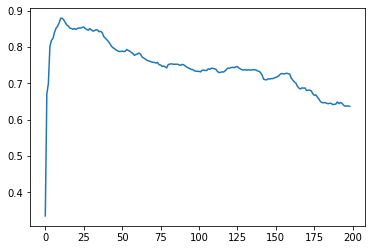

10


In [105]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train = X[train_indices]
X_test = X[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]
accuracy_list = []
for x in x_range:
  accuracy_list.append(calAccuracy(x))
plt.plot(accuracy_list)
plt.show()
print(np.argmax(accuracy_list))

## Game Initialization

In [0]:
mem_size = one_game_steps * 4
batch_size = int(one_game_steps /64) * 64
assert batch_size <= mem_size
random_walk_period = batch_size

accuracy_lookuptb = dict(zip(*(x_range, accuracy_list)))

random_walk_period = batch_size
scaler_state = MinMaxScaler()
scaler_state.fit([detect(detect_range, x) + [x] for x in x_range if np.prod(detect(detect_range, x)) > 0])

x = 190
detection = detect(detect_range, x)
cur_nor_state = scaler_state.transform([detection + [x]])[0]
cur_state = scaler_state.inverse_transform([cur_nor_state])[0]

init_state = cur_state
init_nor_state = cur_nor_state

## Make a NN

In [0]:
def makeModel():
  fc1_dims = 200
  fc2_dims = 200
  model = Sequential([
      Dense(fc1_dims, input_shape=(np.array(cur_state).shape[0],)),
      Activation('relu'),
      Dense(fc2_dims),
      Activation('relu'),
      Dense(len(step_options))
  ])

  model.compile(optimizer=Adam(lr=lr), loss='mse')

  return model

# with strategy.scope():
q_model = makeModel()

## Main

In [108]:
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

reward_his = []

n_games = 10
gamma = 0.5

epsilon = 0.1
epsilon_dec = 0.8

for _ in tqdm(range(n_games)):
  for step_ctr in range(one_game_steps):
    
  # predict action
    if mem_ctr < random_walk_period or np.random.uniform() <= epsilon:
      action = np.random.choice(step_options)
    else:
      # once random walk were done, the state in memory will be normalized

      indices = np.random.choice(len(state_mem), batch_size, replace=False)

      batch_states = np.array(list(state_mem.values()))[indices]
      batch_next_states = np.array(list(next_state_mem.values()))[indices]
      batch_actions = np.array(list(onehot_action_mem.values()))[indices]
      batch_rewards = np.array(list(reward_mem.values()))[indices]

      q_matrix = q_model.predict(batch_states)
      q_next = q_model.predict(batch_next_states)

      actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
      batch_indices = np.arange(batch_size, dtype=np.int64)

      q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1)


      q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

      action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
    
    next_state, reward = step(cur_state, action)
    next_nor_state = scaler_state.transform([next_state])[0]
    
    writeMem(cur_nor_state, next_nor_state, action, reward)
    reward_his.append(reward)

    cur_state = next_state
    cur_nor_state = next_nor_state

    mem_ctr += 1




  0%|          | 0/10 [00:00<?, ?it/s]


 10%|█         | 1/10 [00:01<00:11,  1.33s/it]


 20%|██        | 2/10 [00:06<00:20,  2.54s/it]


 30%|███       | 3/10 [00:12<00:24,  3.50s/it]


 40%|████      | 4/10 [00:18<00:25,  4.18s/it]


 50%|█████     | 5/10 [00:23<00:22,  4.59s/it]


 60%|██████    | 6/10 [00:29<00:19,  4.94s/it]


 70%|███████   | 7/10 [00:35<00:15,  5.16s/it]


 80%|████████  | 8/10 [00:40<00:10,  5.32s/it]


 90%|█████████ | 9/10 [00:46<00:05,  5.45s/it]


100%|██████████| 10/10 [00:52<00:00,  5.47s/it]




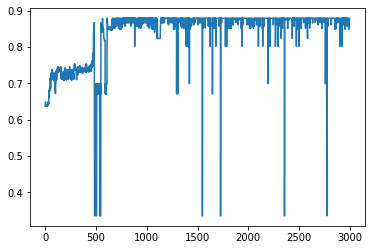

In [109]:
plt.plot(reward_his)

The agent stop at:  (11, 0.8795843718139704)


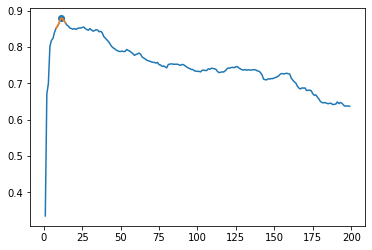

In [111]:
plt.plot(x_range, accuracy_list)
plt.plot(np.array(detect_range) + cur_state[-1], cur_state[:-1])
plt.scatter(cur_state[-1], cur_state[2])
print("The agent stop at: ", (cur_state[-1], cur_state[2]))

## Impact of parameter value in states

In [68]:
cur_state_prediction = q_model.predict(cur_nor_state.reshape(1,6))[0]
cur_state_action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1,6))[0])]
print("Current state: ", cur_state)
print("Action at the current state: ", cur_state_action)

Current state:  [0.75686994 0.83605527 0.83742158 0.85217968 0.8646609  9.        ]
Action at the current state:  3


After reverse the accuracy, the new action of the reversed state =  0


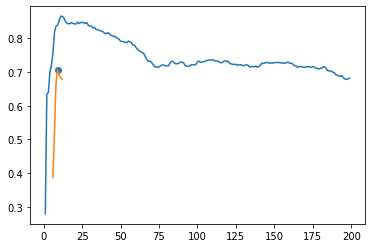

In [58]:
### reverse the accuracy at teh cur_state and normalize it
cur_nor_state_reverse = np.append(1 - np.array(cur_nor_state)[:-1], cur_nor_state[-1])
cur_state_reverse = scaler_state.inverse_transform([cur_nor_state_reverse])[0]
plt.plot(x_range, accuracy_list)
plt.plot(np.array(detect_range) + cur_state_reverse[-1], cur_state_reverse[:-1])
plt.scatter(cur_state_reverse[-1], cur_state_reverse[2])

print("After reverse the accuracy, the new action of the reversed state = ", step_options[np.argmax(q_model.predict([cur_nor_state_reverse.reshape(1, 6)])[0])])

In [85]:
### Change the value of param from 1 to 200
for x in x_range:
  cur_state_tmp = cur_state.copy()
  cur_state_tmp[-1] = x
  cur_nor_state_tmp = scaler_state.transform([cur_state_tmp])[0]
  # print(cur_state_tmp)
  action_tmp = step_options[np.argmax(q_model.predict([cur_nor_state_tmp.reshape(1, 6)])[0])]
  print(x, action_tmp)
  

1 3
2 3
3 3
4 3
5 3
6 3
7 3
8 3
9 3
10 3
11 3
12 3
13 3
14 3
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 3
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 8
38 0
39 0
40 0
41 0
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 0
52 0
53 0
54 0
55 0
56 0
57 0
58 0
59 0
60 0
61 0
62 0
63 0
64 0
65 0
66 0
67 0
68 0
69 0
70 0
71 0
72 0
73 0
74 0
75 0
76 0
77 0
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 0
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 0
94 0
95 0
96 0
97 0
98 0
99 0
100 0
101 0
102 0
103 0
104 0
105 0
106 0
107 0
108 0
109 0
110 0
111 0
112 0
113 0
114 0
115 0
116 0
117 0
118 0
119 0
120 0
121 0
122 0
123 0
124 0
125 0
126 0
127 0
128 0
129 0
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 0
139 0
140 0
141 0
142 0
143 0
144 0
145 0
146 0
147 0
148 0
149 0
150 0
151 0
152 0
153 0
154 0
155 0
156 0
157 0
158 0
159 0
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 0
171 0
172 0
173 0
174 0
175 0
176 0
177 0
178 0
179 0
180 0
181 0
182 0
183 0
184 0
185 

## Test by Changing Test Set

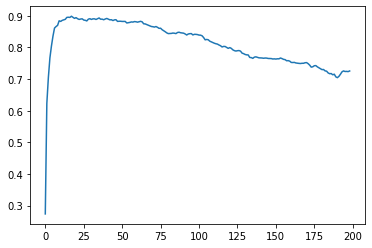

14


In [93]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list_test = []
accuracy_lookuptb_test = {}
for x in x_range:
  accuracy_list_test.append(calAccuracyTest(x))
  accuracy_lookuptb_test[x] = accuracy_list_test[-1]
plt.plot(accuracy_list_test)
plt.show()
print(np.argmax(accuracy_list_test))

  3%|▎         | 6/180 [00:03<01:26,  2.02it/s]


  4%|▍         | 7/180 [00:03<01:23,  2.06it/s]


  4%|▍         | 8/180 [00:03<01:21,  2.11it/s]


  5%|▌         | 9/180 [00:04<01:18,  2.17it/s]


  6%|▌         | 10/180 [00:04<01:15,  2.24it/s]


  6%|▌         | 11/180 [00:05<01:13,  2.31it/s]


  7%|▋         | 12/180 [00:05<01:11,  2.36it/s]


  7%|▋         | 13/180 [00:05<01:08,  2.44it/s]


  8%|▊         | 14/180 [00:06<01:06,  2.50it/s]


  8%|▊         | 15/180 [00:06<01:04,  2.56it/s]


  9%|▉         | 16/180 [00:07<01:02,  2.62it/s]


  9%|▉         | 17/180 [00:07<01:00,  2.70it/s]


 10%|█         | 18/180 [00:07<00:57,  2.81it/s]


 11%|█         | 19/180 [00:08<00:55,  2.91it/s]


 11%|█         | 20/180 [00:08<00:53,  3.00it/s]


 12%|█▏        | 21/180 [00:08<00:51,  3.09it/s]


 12%|█▏        | 22/180 [00:08<00:49,  3.22it/s]


 13%|█▎        | 23/180 [00:09<00:47,  3.31it/s]


 13%|█▎        | 24/180 [00:09<00:45,  3.44it/s]


 14%|█▍        | 25/180 [00:09<00:4

[0.8697007655868235, 0.8821402632654205, 0.8854472890762095, 0.8870146999904113, 0.8948252430858958, 12]
[0.8887524754207043, 0.8953659449961926, 0.8948324872345711, 0.8985055508646816, 0.8917126954143653, 17]


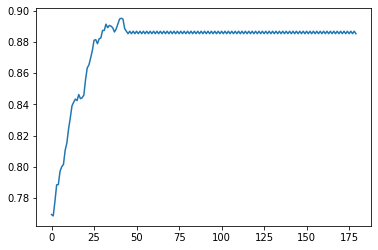

In [113]:
x = 140
detection_test = detectTest(detect_range, x)
cur_nor_state_test = scaler_state.transform([detection_test + [x]])[0]
cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

init_state_test = cur_state_test
init_nor_state_test = cur_nor_state_test
prediction_test = []
cur_state_test = init_state_test
max_state_test = cur_state_test
for step_ctr in tqdm(range(180)):
  action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, 6)))]
  next_state_test, reward_test = stepTest(cur_state_test, action_test)
  if reward_test > max_state_test[3]:
    max_state_test = next_state_test
  next_nor_state_test = scaler_state.transform([next_state_test])[0]
  prediction_test.append(reward_test)
  cur_state_test = next_state_test
  cur_nor_state_test = next_nor_state_test
plt.plot(prediction_test)
print(cur_state_test)
print(max_state_test)

##Test by Changing Test Set 2

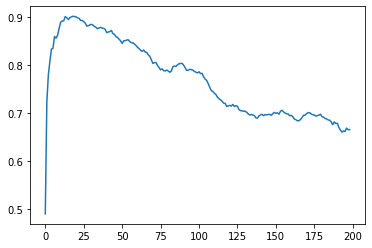

The max value locate at x =  18


In [120]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list_test = []
accuracy_lookuptb_test = {}
for x in x_range:
  accuracy_list_test.append(calAccuracyTest(x))
  accuracy_lookuptb_test[x] = accuracy_list_test[-1]
plt.plot(accuracy_list_test)
plt.show()
print("The max value locate at x = ", np.argmax(accuracy_list_test))




  0%|          | 0/180 [00:00<?, ?it/s]


  1%|          | 1/180 [00:00<01:39,  1.80it/s]

-3 0.6942896945072323 [  0.69428969   0.68903327   0.69356348   0.69548789   0.69413259
 140.        ]





  1%|          | 2/180 [00:01<01:38,  1.81it/s]

-3 0.695431493656228 [0.695431493656228, 0.6956386895036014, 0.6942896945072323, 0.6895186163854903, 0.6935634846862173, 137]





  2%|▏         | 3/180 [00:01<01:38,  1.79it/s]

-3 0.7034841081960433 [0.7034841081960433, 0.6979620212475219, 0.695431493656228, 0.6965510927217579, 0.6942896945072323, 134]





  2%|▏         | 4/180 [00:02<01:36,  1.83it/s]

-3 0.70445669095068 [0.70445669095068, 0.7031602054508627, 0.7034841081960433, 0.7011365009304299, 0.695431493656228, 131]





  3%|▎         | 5/180 [00:02<01:33,  1.86it/s]

-3 0.7150231622344682 [0.7150231622344682, 0.7069490775316598, 0.70445669095068, 0.7045069685188279, 0.7034841081960433, 128]





  3%|▎         | 6/180 [00:03<01:31,  1.89it/s]

-3 0.7141717952743417 [0.7141717952743417, 0.7133162832146305, 0.7150231622344682, 0.7134483158963654, 0.70445669095068, 125]





  4%|▍         | 7/180 [00:03<01:29,  1.93it/s]

-3 0.7132445765242241 [0.7132445765242241, 0.7154765793591286, 0.7141717952743417, 0.7174564516876123, 0.7150231622344682, 122]





  4%|▍         | 8/180 [00:04<01:27,  1.97it/s]

-3 0.7242204373763624 [0.7242204373763624, 0.719783480388792, 0.7132445765242241, 0.7143234791436854, 0.7141717952743417, 119]





  5%|▌         | 9/180 [00:04<01:26,  1.98it/s]

-3 0.7323487325917541 [0.7323487325917541, 0.7270963075588184, 0.7242204373763624, 0.7201895218946164, 0.7132445765242241, 116]





  6%|▌         | 10/180 [00:05<01:23,  2.04it/s]

-3 0.744458861756093 [0.744458861756093, 0.7380744306919113, 0.7323487325917541, 0.729291801253611, 0.7242204373763624, 113]





  6%|▌         | 11/180 [00:05<01:19,  2.12it/s]

-3 0.7606234236966962 [0.7606234236966962, 0.7462143949897486, 0.744458861756093, 0.7405691187688175, 0.7323487325917541, 110]





  7%|▋         | 12/180 [00:06<01:16,  2.18it/s]

-3 0.7748001130874269 [0.7748001130874269, 0.7673986811781881, 0.7606234236966962, 0.7528771108510863, 0.744458861756093, 107]





  7%|▋         | 13/180 [00:06<01:13,  2.26it/s]

-3 0.785406108061944 [0.785406108061944, 0.7820574265593723, 0.7748001130874269, 0.7700812951066597, 0.7606234236966962, 104]





  8%|▊         | 14/180 [00:06<01:10,  2.34it/s]

-3 0.7863903545386065 [0.7863903545386065, 0.7830449053806685, 0.785406108061944, 0.7816775690115046, 0.7748001130874269, 101]





  8%|▊         | 15/180 [00:07<01:08,  2.40it/s]

-3 0.7902988933064132 [0.7902988933064132, 0.788639435172178, 0.7863903545386065, 0.7844721699604416, 0.785406108061944, 98]





  9%|▉         | 16/180 [00:07<01:06,  2.47it/s]

-3 0.7934191020155332 [0.7934191020155332, 0.7888841983118777, 0.7902988933064132, 0.7901444937366745, 0.7863903545386065, 95]





  9%|▉         | 17/180 [00:07<01:04,  2.52it/s]

-3 0.8026824685810284 [0.8026824685810284, 0.7991880709215972, 0.7934191020155332, 0.7880479018670707, 0.7902988933064132, 92]





 10%|█         | 18/180 [00:08<01:02,  2.59it/s]

-3 0.7963479562180849 [0.7963479562180849, 0.8021010418819375, 0.8026824685810284, 0.8028137504477216, 0.7934191020155332, 89]





 11%|█         | 19/180 [00:08<01:00,  2.64it/s]

-3 0.7869630889792236 [0.7869630889792236, 0.7973376350452095, 0.7963479562180849, 0.7998891987039966, 0.8026824685810284, 86]





 11%|█         | 20/180 [00:09<00:59,  2.68it/s]

-3 0.7889899563349478 [0.7889899563349478, 0.7843925975322125, 0.7869630889792236, 0.7959248529713212, 0.7963479562180849, 83]





 12%|█▏        | 21/180 [00:09<00:56,  2.79it/s]

-3 0.7915483361257466 [0.7915483361257466, 0.7872235838624702, 0.7889899563349478, 0.7868785828941706, 0.7869630889792236, 80]





 12%|█▏        | 22/180 [00:09<00:54,  2.92it/s]

-3 0.79862917310629 [0.79862917310629, 0.7894609723960234, 0.7915483361257466, 0.7876870504422392, 0.7889899563349478, 77]





 13%|█▎        | 23/180 [00:09<00:52,  3.00it/s]

-3 0.8027594278054565 [0.8027594278054565, 0.8046395999547677, 0.79862917310629, 0.7938817891969114, 0.7915483361257466, 74]





 13%|█▎        | 24/180 [00:10<00:50,  3.11it/s]

-3 0.820599592059273 [0.820599592059273, 0.8099807613164604, 0.8027594278054565, 0.8045617603885822, 0.79862917310629, 71]





 14%|█▍        | 25/180 [00:10<00:48,  3.22it/s]

-3 0.8306259668503083 [0.8306259668503083, 0.8257685198438618, 0.820599592059273, 0.8175310428413243, 0.8027594278054565, 68]





 14%|█▍        | 26/180 [00:10<00:45,  3.38it/s]

-3 0.8337465533275992 [0.8337465533275992, 0.8279232099589283, 0.8306259668503083, 0.8263627143730854, 0.820599592059273, 65]





 15%|█▌        | 27/180 [00:11<00:43,  3.49it/s]

-3 0.8431168476357755 [0.8431168476357755, 0.836298471487999, 0.8337465533275992, 0.8300846222391873, 0.8306259668503083, 62]





 16%|█▌        | 28/180 [00:11<00:42,  3.61it/s]

-3 0.8480951470018314 [0.8480951470018314, 0.8455357434404968, 0.8431168476357755, 0.8400785479504597, 0.8337465533275992, 59]





 16%|█▌        | 29/180 [00:11<00:40,  3.76it/s]

-3 0.8499730319234378 [0.8499730319234378, 0.8518810820112169, 0.8480951470018314, 0.8458794390150879, 0.8431168476357755, 56]





 17%|█▋        | 30/180 [00:11<00:38,  3.91it/s]

-3 0.8497166783055884 [0.8497166783055884, 0.8498719504634371, 0.8499730319234378, 0.8515691021564418, 0.8480951470018314, 53]





 17%|█▋        | 31/180 [00:12<00:36,  4.09it/s]




-3 0.8582895989763003 [0.8582895989763003, 0.8532880365047426, 0.8497166783055884, 0.8443484485217579, 0.8499730319234378, 50]
-3 0.8713638998197084 [0.8713638998197084, 0.8630523292287651, 0.8582895989763003, 0.8568480712155799, 0.8497166783055884, 47]


 18%|█▊        | 32/180 [00:12<00:34,  4.34it/s]


 18%|█▊        | 33/180 [00:12<00:32,  4.51it/s]


 19%|█▉        | 34/180 [00:12<00:30,  4.85it/s]

-3 0.8666288396020996 [0.8666288396020996, 0.868983561732904, 0.8713638998197084, 0.8648104243168486, 0.8582895989763003, 44]
-3 0.8763513153949638 [0.8763513153949638, 0.8734756687902324, 0.8666288396020996, 0.8681651763699406, 0.8713638998197084, 41]





 19%|█▉        | 35/180 [00:12<00:28,  5.11it/s]


 20%|██        | 36/180 [00:12<00:26,  5.38it/s]

-3 0.8748694312612431 [0.8748694312612431, 0.8777575816906972, 0.8763513153949638, 0.8755288052507463, 0.8666288396020996, 38]
-3 0.8823927883332267 [0.8823927883332267, 0.877974422487833, 0.8748694312612431, 0.8768653750563724, 0.8763513153949638, 35]





 21%|██        | 37/180 [00:13<00:25,  5.72it/s]


 21%|██        | 38/180 [00:13<00:22,  6.23it/s]

-3 0.8813221669227073 [0.8813221669227073, 0.884149417181618, 0.8823927883332267, 0.8794247563309687, 0.8748694312612431, 32]
-3 0.8898003279483134 [0.8898003279483134, 0.8803904986142209, 0.8813221669227073, 0.8828568411103035, 0.8823927883332267, 29]





 22%|██▏       | 39/180 [00:13<00:21,  6.71it/s]


 22%|██▏       | 40/180 [00:13<00:19,  7.34it/s]

-3 0.8963221005414188 [0.8963221005414188, 0.8920574167310127, 0.8898003279483134, 0.8866806302304435, 0.8813221669227073, 26]
-3 0.9002649158478 [0.9002649158478, 0.8974783671356055, 0.8963221005414188, 0.8921605455496697, 0.8898003279483134, 23]
-3 0.8980057230274456 [0.8980057230274456, 0.9009172813885657, 0.9002649158478, 0.8996377796368077, 0.8963221005414188, 20]





 23%|██▎       | 42/180 [00:13<00:16,  8.33it/s]


 24%|██▍       | 44/180 [00:13<00:14,  9.46it/s]

-1 0.8941381383226171 [0.9002634168666237, 0.8941381383226171, 0.8980057230274456, 0.8995719398415669, 0.9002649158478, 17]
-1 0.8977380898326774 [0.8913961100688778, 0.8977380898326774, 0.8941381383226171, 0.8980057230274456, 0.9009172813885657, 16]
-1 0.9002634168666237 [0.8910802865688103, 0.9002634168666237, 0.8977380898326774, 0.8941381383226171, 0.8995719398415669, 15]





 26%|██▌       | 46/180 [00:13<00:12, 10.49it/s]




-1 0.8913961100688778 [0.8886720499310186, 0.8913961100688778, 0.9002634168666237, 0.8977380898326774, 0.8980057230274456, 14]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 27%|██▋       | 48/180 [00:14<00:11, 11.47it/s]


 28%|██▊       | 50/180 [00:14<00:10, 12.26it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 29%|██▉       | 52/180 [00:14<00:10, 12.48it/s]


 30%|███       | 54/180 [00:14<00:09, 13.16it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 31%|███       | 56/180 [00:14<00:09, 13.13it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 




 32%|███▏      | 58/180 [00:14<00:09, 13.48it/s]


 33%|███▎      | 60/180 [00:14<00:09, 12.95it/s]

[0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 34%|███▍      | 62/180 [00:15<00:08, 13.31it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 36%|███▌      | 64/180 [00:15<00:08, 13.50it/s]


 37%|███▋      | 66/180 [00:15<00:08, 13.67it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 38%|███▊      | 68/180 [00:15<00:08, 13.57it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 39%|███▉      | 70/180 [00:15<00:07, 14.00it/s]


 40%|████      | 72/180 [00:15<00:07, 14.17it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 41%|████      | 74/180 [00:15<00:07, 13.83it/s]


 42%|████▏     | 76/180 [00:16<00:07, 13.52it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 43%|████▎     | 78/180 [00:16<00:07, 13.81it/s]


 44%|████▍     | 80/180 [00:16<00:07, 14.22it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 46%|████▌     | 82/180 [00:16<00:06, 14.52it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 47%|████▋     | 84/180 [00:16<00:06, 14.48it/s]


 48%|████▊     | 86/180 [00:16<00:06, 14.48it/s]


 49%|████▉     | 88/180 [00:16<00:06, 14.63it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 50%|█████     | 90/180 [00:17<00:06, 14.64it/s]


 51%|█████     | 92/180 [00:17<00:05, 14.76it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 52%|█████▏    | 94/180 [00:17<00:05, 14.68it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 53%|█████▎    | 96/180 [00:17<00:06, 13.80it/s]


 54%|█████▍    | 98/180 [00:17<00:05, 14.08it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 56%|█████▌    | 100/180 [00:17<00:05, 14.20it/s]


 57%|█████▋    | 102/180 [00:17<00:05, 14.40it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 58%|█████▊    | 104/180 [00:17<00:05, 14.38it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 59%|█████▉    | 106/180 [00:18<00:05, 13.99it/s]


 60%|██████    | 108/180 [00:18<00:05, 14.09it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 61%|██████    | 110/180 [00:18<00:04, 14.06it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 62%|██████▏   | 112/180 [00:18<00:04, 14.16it/s]


 63%|██████▎   | 114/180 [00:18<00:04, 14.13it/s]


 64%|██████▍   | 116/180 [00:18<00:04, 14.51it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 66%|██████▌   | 118/180 [00:18<00:04, 14.57it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 67%|██████▋   | 120/180 [00:19<00:04, 14.69it/s]


 68%|██████▊   | 122/180 [00:19<00:03, 14.51it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 69%|██████▉   | 124/180 [00:19<00:03, 14.50it/s]


 70%|███████   | 126/180 [00:19<00:03, 14.53it/s]


 71%|███████   | 128/180 [00:19<00:03, 14.52it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 72%|███████▏  | 130/180 [00:19<00:03, 14.08it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 




 73%|███████▎  | 132/180 [00:19<00:03, 13.89it/s]


 74%|███████▍  | 134/180 [00:20<00:03, 13.94it/s]

[0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 76%|███████▌  | 136/180 [00:20<00:03, 14.02it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 77%|███████▋  | 138/180 [00:20<00:03, 13.72it/s]


 78%|███████▊  | 140/180 [00:20<00:02, 13.77it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 79%|███████▉  | 142/180 [00:20<00:02, 13.94it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 80%|████████  | 144/180 [00:20<00:02, 14.12it/s]


 81%|████████  | 146/180 [00:20<00:02, 13.89it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 82%|████████▏ | 148/180 [00:21<00:02, 13.90it/s]


 83%|████████▎ | 150/180 [00:21<00:02, 14.34it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 84%|████████▍ | 152/180 [00:21<00:01, 14.51it/s]


 86%|████████▌ | 154/180 [00:21<00:01, 14.78it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 87%|████████▋ | 156/180 [00:21<00:01, 14.69it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 88%|████████▊ | 158/180 [00:21<00:01, 14.65it/s]


 89%|████████▉ | 160/180 [00:21<00:01, 14.51it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 90%|█████████ | 162/180 [00:22<00:01, 14.47it/s]


 91%|█████████ | 164/180 [00:22<00:01, 14.17it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 92%|█████████▏| 166/180 [00:22<00:01, 13.90it/s]


 93%|█████████▎| 168/180 [00:22<00:00, 13.87it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





 94%|█████████▍| 170/180 [00:22<00:00, 13.78it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]


 96%|█████████▌| 172/180 [00:22<00:00, 13.98it/s]


 97%|█████████▋| 174/180 [00:22<00:00, 14.00it/s]

1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]





 98%|█████████▊| 176/180 [00:23<00:00, 13.60it/s]


 99%|█████████▉| 178/180 [00:23<00:00, 13.83it/s]

-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]





100%|██████████| 180/180 [00:23<00:00, 13.69it/s]




1 0.8913961100688778 [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
-1 0.8910802865688103 [0.8757967866700117, 0.8910802865688103, 0.8913961100688778, 0.9002634168666237, 0.8941381383226171, 13]
Cur state:  [0.8612259170334173, 0.8886720499310186, 0.8910802865688103, 0.8913961100688778, 0.8977380898326774, 12]
Max state found:  [0.8886720499310186, 0.8913961100688778, 0.9002634168666237, 0.8977380898326774, 0.8980057230274456, 14]


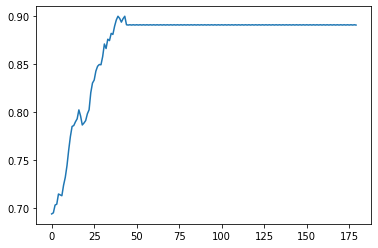

In [125]:
x = 140
detection_test = detectTest(detect_range, x)
cur_nor_state_test = scaler_state.transform([detection_test + [x]])[0]
cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

init_state_test = cur_state_test
init_nor_state_test = cur_nor_state_test
prediction_test = []
cur_state_test = init_state_test
max_state_test = cur_state_test
for step_ctr in tqdm(range(180)):
  action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, 6)))]
  while (action_test == 0):
    action_test = np.random.choice(step_options)
  next_state_test, reward_test = stepTest(cur_state_test, action_test)
  print(action_test, reward_test, cur_state_test)
  if reward_test > max_state_test[3]:
    max_state_test = next_state_test
  next_nor_state_test = scaler_state.transform([next_state_test])[0]
  prediction_test.append(reward_test)
  cur_state_test = next_state_test
  cur_nor_state_test = next_nor_state_test
plt.plot(prediction_test)
print("Cur state: ", cur_state_test)
print("Max state found: ", max_state_test)

##Test by Changing Test Set with random variable

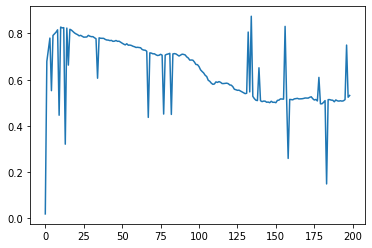

The max value locate at x =  134


In [126]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list_test = []
accuracy_lookuptb_test = {}
for x in x_range:
  if np.random.uniform() > 0.1:
    accuracy_list_test.append(calAccuracyTest(x))
  else:
    accuracy_list_test.append(np.random.uniform())
  accuracy_lookuptb_test[x] = accuracy_list_test[-1]
plt.plot(accuracy_list_test)
plt.show()
print("The max value locate at x = ", np.argmax(accuracy_list_test))




  0%|          | 0/180 [00:00<?, ?it/s]


  1%|          | 1/180 [00:00<01:46,  1.68it/s]


  1%|          | 2/180 [00:01<01:41,  1.75it/s]


  2%|▏         | 3/180 [00:01<01:36,  1.84it/s]


  2%|▏         | 4/180 [00:02<01:30,  1.94it/s]


  3%|▎         | 5/180 [00:02<01:25,  2.04it/s]


  3%|▎         | 6/180 [00:02<01:22,  2.11it/s]


  4%|▍         | 7/180 [00:03<01:17,  2.23it/s]


  4%|▍         | 8/180 [00:03<01:13,  2.33it/s]


  5%|▌         | 9/180 [00:04<01:10,  2.44it/s]


  6%|▌         | 10/180 [00:04<01:07,  2.53it/s]


  6%|▌         | 11/180 [00:04<01:03,  2.65it/s]


  7%|▋         | 12/180 [00:05<01:01,  2.75it/s]


  7%|▋         | 13/180 [00:05<00:57,  2.92it/s]


  8%|▊         | 14/180 [00:05<00:52,  3.16it/s]


  8%|▊         | 15/180 [00:05<00:48,  3.38it/s]


  9%|▉         | 16/180 [00:06<00:43,  3.77it/s]


  9%|▉         | 17/180 [00:06<00:38,  4.26it/s]


 10%|█         | 18/180 [00:06<00:33,  4.87it/s]


 11%|█         | 19/180 [00:06<00:28,  5.61it/

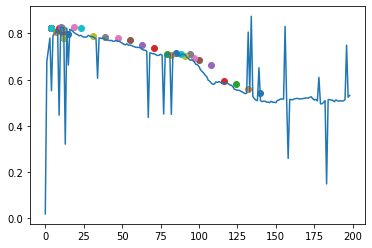

Cur state:  [0.8157031921056532, 0.8276210002776859, 0.8239320842473363, 0.8250754375572018, 0.8232339162639802, 12]
Max state found:  [0.7984912941626591, 0.8157031921056532, 0.8221839012115699, 0.8276210002776859, 0.8250754375572018, 10]


In [131]:
x = 140
detection_test = detectTest(detect_range, x)
cur_nor_state_test = scaler_state.transform([detection_test + [x]])[0]
cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

init_state_test = cur_state_test
init_nor_state_test = cur_nor_state_test
prediction_test = []
cur_state_test = init_state_test
max_state_test = cur_state_test
for step_ctr in tqdm(range(180)):
  action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, 6)))]
  while (action_test == 0):
    action_test = np.random.choice(step_options)
  next_state_test, reward_test = stepTest(cur_state_test, action_test)
  plt.scatter([next_state_test[-1]], [reward_test])
  if reward_test > max_state_test[3]:
    max_state_test = next_state_test
  next_nor_state_test = scaler_state.transform([next_state_test])[0]
  prediction_test.append(reward_test)
  cur_state_test = next_state_test
  cur_nor_state_test = next_nor_state_test
# plt.plot(prediction_test)
plt.plot(accuracy_list_test)
plt.show()
print("Cur state: ", cur_state_test)
print("Max state found: ", max_state_test)

## Test by Changing Test Set with random variable 2

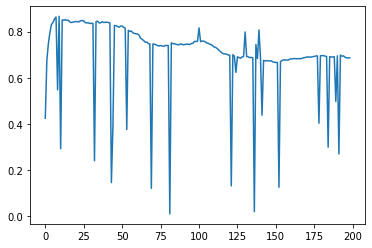

The max value locate at x =  9


In [147]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list_test = []
accuracy_lookuptb_test = {}
for x in x_range:
  if np.random.uniform() > 0.1:
    accuracy_list_test.append(calAccuracyTest(x))
  else:
    accuracy_list_test.append(np.random.uniform())
  accuracy_lookuptb_test[x] = accuracy_list_test[-1]
plt.plot(accuracy_list_test)
plt.show()
print("The max value locate at x = ", np.argmax(accuracy_list_test))




  0%|          | 0/180 [00:00<?, ?it/s]


 10%|█         | 18/180 [00:00<00:00, 176.13it/s]


 21%|██        | 37/180 [00:00<00:00, 179.34it/s]

0.6728914631213061 140.0 8
0.6736564996698409 148 -3
0.6728621888219822 145 -1
0.6853938955492207 144 -3
0.6905499841859755 141 -8
0.6915498144921806 133 -3
0.6901065723347051 130 -1
0.6905592450816677 129 -3
0.6994097100959482 126 -3
0.697953214954208 123 -3
0.7033151147860157 120 -3
0.7186820421882364 117 -3
0.7324070800731705 114 -3
0.7446304084721989 111 -3
0.7562750838130117 108 -3
0.7560788299873639 105 -3
0.7567800083600627 102 -3
0.7477333457779722 99 -3
0.7454356132250874 96 -3
0.7440242831439972 93 -3
0.7435465352371055 90 -3
0.7470173246701168 87 -3
0.7393978123815976 84 -3
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8





 31%|███       | 56/180 [00:00<00:00, 181.26it/s]


 42%|████▏     | 75/180 [00:00<00:00, 183.68it/s]

0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976




 53%|█████▎    | 95/180 [00:00<00:00, 185.87it/s]


 63%|██████▎   | 114/180 [00:00<00:00, 187.01it/s]

 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8





 74%|███████▍  | 133/180 [00:00<00:00, 187.02it/s]


 84%|████████▍ | 152/180 [00:00<00:00, 186.98it/s]

0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976




 94%|█████████▍| 170/180 [00:00<00:00, 182.28it/s]


100%|██████████| 180/180 [00:00<00:00, 184.16it/s]

 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8
0.7393978123815976 73 8
0.7424979797274458 81 -8


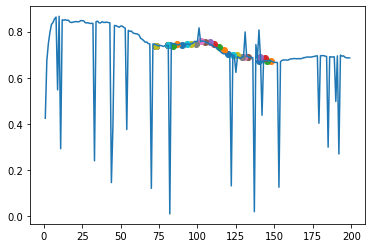

Cur state:  [0.12086261479215177, 0.7450027336704494, 0.7424979797274458, 0.7393290623985922, 0.7397732505179639, 73]
Max state found:  [0.6872366021261636, 0.6901065723347051, 0.6915498144921806, 0.798144863577895, 0.6905499841859755, 130]


In [148]:
x = 140
detection_test = detectTest(detect_range, x)
cur_nor_state_test = scaler_state.transform([detection_test + [x]])[0]
cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

init_state_test = cur_state_test
init_nor_state_test = cur_nor_state_test
prediction_test = []
cur_state_test = init_state_test
max_state_test = cur_state_test
for step_ctr in tqdm(range(180)):
  action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, 6)))]
  while (action_test == 0):
    action_test = np.random.choice([1, -1])
  next_state_test, reward_test = stepTest(cur_state_test, action_test)
  plt.scatter([next_state_test[-1]], [reward_test])
  print(reward_test, cur_state_test[-1], action_test)
  if reward_test > max_state_test[3]:
    max_state_test = next_state_test
  next_nor_state_test = scaler_state.transform([next_state_test])[0]
  prediction_test.append(reward_test)
  cur_state_test = next_state_test
  cur_nor_state_test = next_nor_state_test
# plt.plot(prediction_test)
plt.plot(x_range, accuracy_list_test)
plt.show()
print("Cur state: ", cur_state_test)
print("Max state found: ", max_state_test)

## Test by non-relevant function

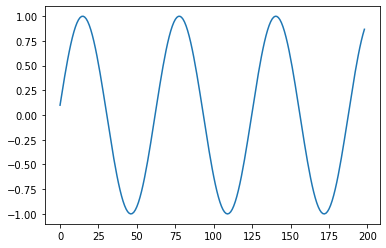

The max value locate at x =  15


In [157]:
X = np.concatenate((X_train, X_test))
Y = np.concatenate((Y_train, Y_test))
train_indices = np.random.choice(X.shape[0], 300, replace=False)
test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
X_train_test = X[train_indices]
X_test_test = X[test_indices]
Y_train_test = Y[train_indices]
Y_test_test = Y[test_indices]
accuracy_list_test = []
accuracy_lookuptb_test = {}
for x in x_range:
  if np.random.uniform() > 0:
    accuracy_list_test.append(np.sin(x/10))
  else:
    accuracy_list_test.append(np.random.uniform())
  accuracy_lookuptb_test[x] = accuracy_list_test[-1]
plt.plot(accuracy_list_test)
plt.show()
print("The max value locate at x = ", np.argmax(accuracy_list_test))




  0%|          | 0/180 [00:00<?, ?it/s]


  9%|▉         | 17/180 [00:00<00:00, 168.01it/s]


 21%|██        | 38/180 [00:00<00:00, 177.20it/s]

0.32747443913769303 120.99999999999999 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913




 31%|███       | 56/180 [00:00<00:00, 176.58it/s]


 42%|████▏     | 75/180 [00:00<00:00, 180.20it/s]

129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 1




 52%|█████▏    | 94/180 [00:00<00:00, 181.22it/s]


 63%|██████▎   | 113/180 [00:00<00:00, 181.36it/s]

0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8





 73%|███████▎  | 131/180 [00:00<00:00, 178.30it/s]


 83%|████████▎ | 149/180 [00:00<00:00, 176.14it/s]

-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8





 93%|█████████▎| 167/180 [00:00<00:00, 175.06it/s]


100%|██████████| 180/180 [00:01<00:00, 177.94it/s]

0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8
0.32747443913769303 121 8
-0.44964746453460147 129 -8


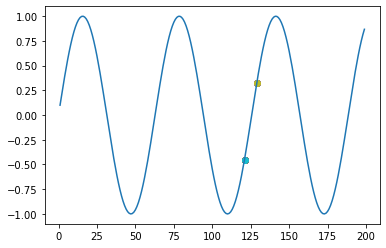

Cur state:  [-0.6935250847771224, -0.5365729180004349, -0.44964746453460147, -0.3582292822368287, -0.1656041754483094, 121]
Max state found:  [0.033623047221136695, 0.23150982510153895, 0.32747443913769303, 0.4201670368266409, 0.592073514707223, 129]


In [163]:
x = 121
detection_test = detectTest(detect_range, x)
cur_nor_state_test = scaler_state.transform([detection_test + [x]])[0]
cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

init_state_test = cur_state_test
init_nor_state_test = cur_nor_state_test
prediction_test = []
cur_state_test = init_state_test
max_state_test = cur_state_test
for step_ctr in tqdm(range(180)):
  action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, 6)))]
  while (action_test == 0):
    action_test = np.random.choice([1, -1])
  next_state_test, reward_test = stepTest(cur_state_test, action_test)
  plt.scatter([next_state_test[-1]], [reward_test])
  print(reward_test, cur_state_test[-1], action_test)
  if reward_test > max_state_test[3]:
    max_state_test = next_state_test
  next_nor_state_test = scaler_state.transform([next_state_test])[0]
  prediction_test.append(reward_test)
  cur_state_test = next_state_test
  cur_nor_state_test = next_nor_state_test
# plt.plot(prediction_test)
plt.plot(x_range, accuracy_list_test)
plt.show()
print("Cur state: ", cur_state_test)
print("Max state found: ", max_state_test)

## Generate 1000 graphs







  0%|          | 0/30 [00:00<?, ?it/s]





  3%|▎         | 1/30 [00:13<06:31, 13.51s/it]





  7%|▋         | 2/30 [00:26<06:16, 13.43s/it]





 10%|█         | 3/30 [00:40<06:04, 13.50s/it]





 13%|█▎        | 4/30 [00:54<05:52, 13.54s/it]





 17%|█▋        | 5/30 [01:07<05:39, 13.57s/it]





 20%|██        | 6/30 [01:21<05:24, 13.51s/it]





 23%|██▎       | 7/30 [01:34<05:09, 13.47s/it]





 27%|██▋       | 8/30 [01:47<04:54, 13.37s/it]





 30%|███       | 9/30 [02:01<04:41, 13.41s/it]





 33%|███▎      | 10/30 [02:14<04:26, 13.34s/it]





 37%|███▋      | 11/30 [02:27<04:13, 13.36s/it]





 40%|████      | 12/30 [02:40<03:58, 13.27s/it]





 43%|████▎     | 13/30 [02:54<03:46, 13.31s/it]





 47%|████▋     | 14/30 [03:07<03:31, 13.23s/it]





 50%|█████     | 15/30 [03:20<03:18, 13.25s/it]





 53%|█████▎    | 16/30 [03:33<03:04, 13.20s/it]





 57%|█████▋    | 17/30 [03:46<02:51, 13.18s/it]





 60%|██████    | 18/30 [03:59<02:37, 13.11s/it]





 63%|

ValueError: ignored

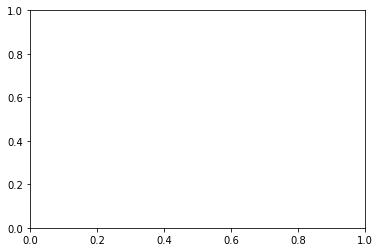

In [175]:
max_x_list = []
converge_x_list = []

for _ in tqdm(range(30)):
  X = np.concatenate((X_train, X_test))
  Y = np.concatenate((Y_train, Y_test))
  train_indices = np.random.choice(X.shape[0], 300, replace=False)
  test_indices = np.array([x for x in range(X.shape[0]) if x not in train_indices])
  X_train_test = X[train_indices]
  X_test_test = X[test_indices]
  Y_train_test = Y[train_indices]
  Y_test_test = Y[test_indices]
  accuracy_list_test = []
  accuracy_lookuptb_test = {}
  for x in x_range:
    if np.random.uniform() > 0:
      accuracy_list_test.append(calAccuracyTest(x))
    else:
      accuracy_list_test.append(np.random.uniform())
    accuracy_lookuptb_test[x] = accuracy_list_test[-1]
  max_x_list.append(np.argmax(accuracy_list_test))


  x = 121
  detection_test = detectTest(detect_range, x)
  cur_nor_state_test = scaler_state.transform([detection_test + [x]])[0]
  cur_state_test = scaler_state.inverse_transform([cur_nor_state_test])[0]

  init_state_test = cur_state_test
  init_nor_state_test = cur_nor_state_test
  prediction_test = []
  cur_state_test = init_state_test
  max_state_test = cur_state_test
  for step_ctr in range(180):
    action_test = step_options[np.argmax(q_model.predict(cur_nor_state_test.reshape(1, 6)))]
    while (action_test == 0):
      action_test = np.random.choice([1, -1])
    next_state_test, reward_test = stepTest(cur_state_test, action_test)
    # plt.scatter([next_state_test[-1]], [reward_test])
    # print(reward_test, cur_state_test[-1], action_test)
    if reward_test > max_state_test[3]:
      max_state_test = next_state_test
    next_nor_state_test = scaler_state.transform([next_state_test])[0]
    prediction_test.append(reward_test)
    cur_state_test = next_state_test
    cur_nor_state_test = next_nor_state_test
  # plt.plot(prediction_test)

  converge_x_list.append(cur_state_test[-1])
  # print("Cur state: ", cur_state_test)
  # print("Max state found: ", max_state_test)

plt.plot(range(30), max_x_list)
plt.scatter(range(30), converge_x_list)

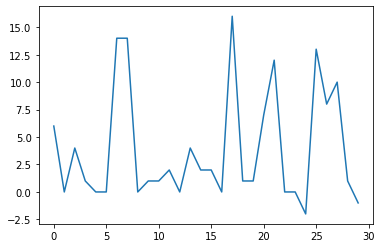

In [178]:
plt.plot(np.array(max_x_list) - np.array(converge_x_list))

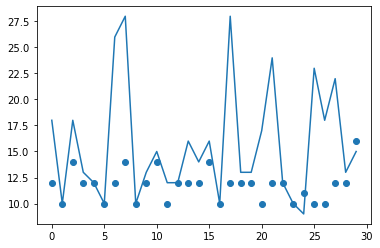

In [176]:
plt.plot(range(30), max_x_list)
plt.scatter(range(30), converge_x_list)